# Apply Wasserstein distance estimator(WDE) to time series models
# AR(1)_SWD

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import shgo

import ot
import ot.plot

c:\Users\Xiaoyu Huang\AppData\Local\Programs\Python\Python310\lib\site-packages\ot\backend.py:2998: UserWarning: To use TensorflowBackend, you need to activate the tensorflow numpy API. You can activate it by running: 
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()
  register_backend(TensorflowBackend())


## AR(1) Model:

we consider is an autoregressive model of order 1 : 
$$x_{t} = a_1 x_{t-1}+ \epsilon _t $$
where $\epsilon_t \sim  \mathcal{N}  (0,1)$

In [11]:
def AR_1(a_1, _RNG_SEED,T):
    '''
    ------------------------
    Creating a AR(1) generated time series
    
    Returns:
    X: list (T x 2)
        Generated time series where each row is [x_{t-1}, x_{t}]
    ------------------------
    Parameters
    a_1: float
        The true a_1 paramter in the AR(1) model

    _RNG_SEED: int
        Fix a random seed when generate the time series

    T: int
        Number of periods in the time series
    '''

    x_0 = 0.2   # initial value
    mu, sigma = 0, 1    # mean and std of the iid random shocks epsilon_t
    X = np.zeros((T,2)) # matrix of (x_{t-1}, x_{t})
    np.random.seed(_RNG_SEED)   # fix the random seed 
    random_shock = np.random.normal(mu, sigma,size = T)

    for time in range(T):
        x_1 = a_1*x_0 + random_shock[time]
        X[time,0] = x_0
        X[time,1] = x_1
        x_0 = x_1
    
    return X

# Define function that generate (T x K) simulated time series return from AR_1 model 
def AR_1_draws(a_1,K,T):
    '''
    ------------------------
    Create a number of simulated time series return from AR_1 model 
    
    Returns:
    AR_1_draws: numpy array (T x K)
        Generated times series of shape T x K
    ------------------------
    a_1: int
        True parameter a_1 in the AR(1) model

    K: int
        The number of random seeds 

    T: int
        Length of each simulated time series
    '''
    AR_1_draws = []
    for seed in range(K): # random seeds will be [0,...., num_seeds-1]
        ar_1_response = AR_1(a_1,seed,T)
        AR_1_draws.append(ar_1_response)
    AR_1_draws = np.array(AR_1_draws)
    
    return AR_1_draws

def cost_fun_WD_AR_1(a_1,real_data,K,N,m):   
    '''
    ------------------------
    Compute the sliced Wasserstein distance between the true time series distribution and 
    the one generated by assumed parameter a_1
    
    Returns:
    cost_val_WD: float
        The computed Wassertein distance
    ------------------------
    a_1: int
        Assumed parameter a_1 in the AR(1) model

    real_data:
        The true time series observed

    K: int
        The number of random seeds used to generate simulated data

    N: int
        Length of each simulated time series

    m: int
        Seed used for random number generator in the Sliced Wasserstein distance
        computation
    ''' 

    sim_data = AR_1_draws(a_1,K,N)
    
    # compute the sliced Wasserstein distance K times
    wasserstein_dises_k = []
    for seed in range(K):
        wasserstein_dis = ot.max_sliced_wasserstein_distance(real_data, sim_data[seed,:,:], n_projections=50,seed=m)
        wasserstein_dises_k.append(wasserstein_dis)
        
    # Save the expected sliced Wasserstein distance between real data and K simulated time series  
    wasserstein_dises_k_mean = np.average(np.array(wasserstein_dises_k))
    cost_val_WD = wasserstein_dises_k_mean

    return cost_val_WD

def optim(N,K,M,true_param_AR_1):
    '''
    ------------------------
    Optimizer to find the best estimated a_1. We compute the estimations that minimizes 
    the sliced Wasserstein distance between true time series and simulated one M time. 

    
    Returns:
    results_ar_1: list (length M)
        The best estimated a_1 in M rounds estimations
    ------------------------
    N: int
        Length of each simulated time series

    K: int
        The number of random seeds used to generate simulated data

    M: int
        The number of estimations

    true_param_AR_1: float
        The true a_1 paramter in the AR(1) model
    ''' 
    
    minimizer_kwargs = {"method": 'SLSQP'} # local optimizer in the SHGO algorithm
    # Choices are {BFGS, L-BFGS-B, SLSQP}  

    results_ar_1=[]
    bnds = [(-1, 1)]   # bounds for parameter exploration

    # Estimations
    for m in range(M):
        real_data_AR_1 =AR_1(a_1 = true_param_AR_1, _RNG_SEED = m ,T = N)
        smm_args_ar_1 = (real_data_AR_1,K,N,m)
        result = shgo(cost_fun_WD_AR_1, bounds=bnds, args=(smm_args_ar_1), minimizer_kwargs=minimizer_kwargs, n = 16, sampling_method='sobol',options={'eps': 0.0001})
        if result.success == True:
            results_ar_1.append(result.x)

    return results_ar_1

C:\Users\Xiaoyu Huang\AppData\Local\Temp\ipykernel_22888\3693094794.py:30: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X[time,1] = x_1
C:\Users\Xiaoyu Huang\AppData\Local\Temp\ipykernel_22888\3693094794.py:29: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X[time,0] = x_0


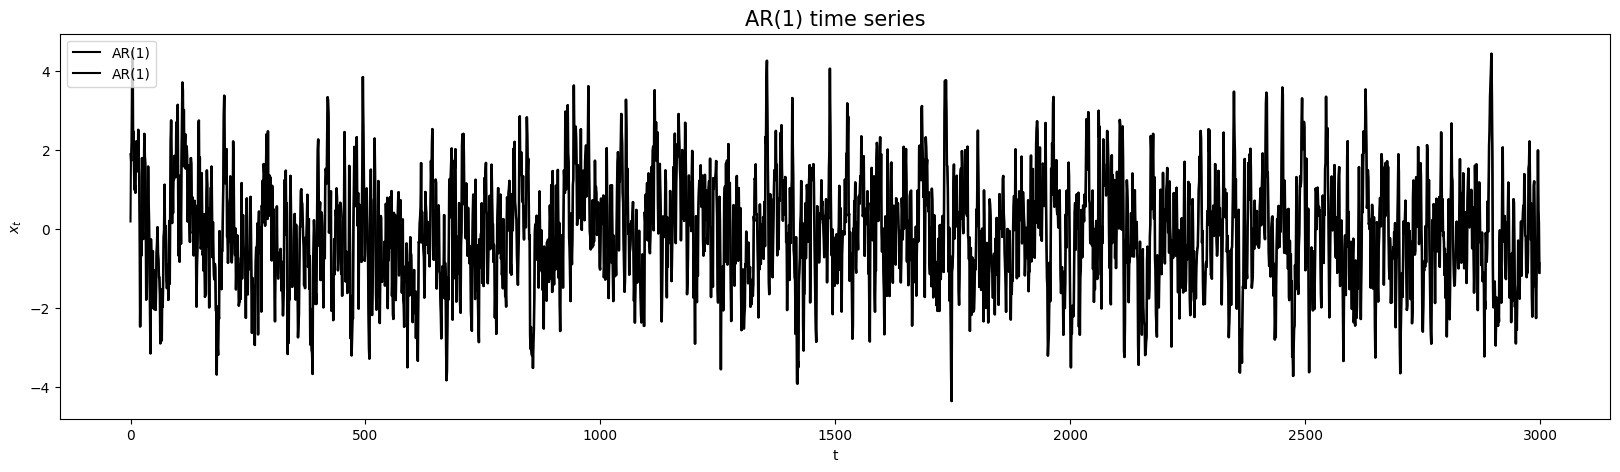

The parameter to be estimated is:
 [0.7]


In [7]:
# A sample true time series generated by the true parameter
true_param_AR_1 = np.array([0.7])
real_data_AR_1 = AR_1(a_1 = true_param_AR_1, _RNG_SEED = 0 ,T = 3000)

# plot
plt.figure(figsize=(20, 5))
plt.plot(real_data_AR_1, color='k', label='AR(1)')
plt.title('AR(1) time series', fontsize=15)
plt.xlabel('t')
plt.ylabel('$x_t$')
plt.legend(loc='upper left')
plt.show()
print("The parameter to be estimated is:\n",true_param_AR_1)

In [9]:
# Estimation hyperparameters
N_set = [100] # time series length. Try 1000
K_set = [3] # number of simulated time series by each set of parameter. Try 3
M = 500 # Monte Carlo replications of estimations

In [13]:
results = {}

# compute the estimations
for N in N_set:
    for K in K_set:
        print("N = {} and K = {}".format(N,K))
        results[N,K] = optim (N,K,M,true_param_AR_1)

# plot the distribution of estimations, final estimation, and true parameter a_1
for N in N_set:
    for K in K_set:
        print("N = {} and K = {}".format(N,K))
        a_1_hat = round(np.array(results[N,K]).reshape(-1).mean(),4)
        print("Estimtaed a_1 = {}".format(a_1_hat))

        plt.figure(figsize=(8, 5))
        kwargs = dict(alpha=0.4, bins=20)
        sns.kdeplot(np.array(results[N,K]).reshape(-1), color='g', bw_adjust=0.5,fill=False)
        plt.hist(np.array(results[N,K]).reshape(-1), density=True, **kwargs, color='g', label='Density of $a_1$')
        hat_a1 = "{} = {}".format("$\hat{a}_{1}$", a_1_hat)
        plt.axvline(np.array(results[N,K]).reshape(-1).mean(), 0,5,color='black',linestyle='-',linewidth=1,label= hat_a1)
        plt.axvline(0.7, 0,5,color='r',linestyle='-',linewidth=1,label='$a_1^*$ = 0.7')
        plt.gca().set(title='The empirical distribution of parameter $a_1$', xlabel='$a_1$', ylabel='Density')
        plt.xlim(-0.1,1)
        plt.legend()

N = 100 and K = 3


C:\Users\Xiaoyu Huang\AppData\Local\Temp\ipykernel_22888\2143405006.py:30: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X[time,1] = x_1
C:\Users\Xiaoyu Huang\AppData\Local\Temp\ipykernel_22888\2143405006.py:29: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X[time,0] = x_0
